In [2]:
import pandas as pd
pd.set_option('display.max_colwidth', -1)

import numpy as np
from scipy import stats
from sklearn import metrics
import matplotlib.pyplot as plt
from math import ceil
%matplotlib notebook

Site = 'FishIsland'
Site = 'Illisarvik'
Data_Path = 'C:/Users/wesle/NetworkAnalysis/'+Site+'/'#'Data_Footprints_2018-06-12.csv'
Data = pd.read_csv(Data_Path+'ECData.csv')
Data = Data.set_index(pd.DatetimeIndex(Data.datetime))
Data = Data.drop('datetime',axis=1)
# print(Data['PPFD_Avg'])

# Data = Data.interpolate().bfill()
# Data = Data.interpolate().ffill()

Data['fco2']*= 1e-6 * 44.0095 *3600
Data['fch4']*= 1e-3 * 16.04246 *3600

aliases={'wind_speed':'$\overline{U}$','PPFD_Avg':'PPFD',
        'AirTC_Avg':'T$_{a}$','Out_of_Basin':'F$_{out}$',
        'Sedge':'F$_{sdg}$','air_pressure':'P$_{a}$',
        'Shrub':'F$_{shb}$','Sparse':'F$_{spr}$','Grass':'F$_{grs}$'
         ,'Temp':'T$_{s}$','H':'$H$','VPD':'$VPD$','VWC':'$VWC$',
        'Water Table': 'W$_{TBL}$','Active Layer':'AL',
        'Wind Spd':'$\overline{U}$','24H Rain':'24HR','Wtr Tbl Trnd':'d Wtr Tbl',
        'air pressure':'P$_{a}$','Ta':'T$_{a}$','Rn':'Rn','PPFD':'PPFD','Rain':'Rain',
        'Ts 2.5 cm':'T$_{2.5cm}$','Ts 15 cm':'T$_{15cm}$'}
def Read(Data_Path,var,aliases):
    Filling_Path = Data_Path+var+'/GapFilled.csv'
    Filling = pd.read_csv(Filling_Path)
    Filling = Filling.set_index(pd.DatetimeIndex(Filling.datetime))
    Summary_Path = Data_Path+var+'/GapFillingSummary.csv'
    Runs = pd.read_csv(Summary_Path).drop('Unnamed: 0',axis=1)
#     print(Runs.head())
    Runs['Name']=''
    Runs['Foundation']=''
    Group = Runs.groupby('Key').agg({'Model': 'first', 'Foundation': 'first','Name': 'first', 
                                    'Level': 'first','MAE': 'mean', 'R2': 'mean'})
    Group['SE'] = Runs[['Key','MAE']].groupby('Key').sem()
    Group = Group.reset_index()
#     print(Group['MAE'].sem())
#     Group['SE'] = Runs[['Key','MAE']].groupby('Key').sem()
    Runs.loc[Runs['Level']==0,'Best'] = 'Best'    
    Levels = Group.groupby('Level').min()
    Sub=Group[Group['MAE'].isin(Levels['MAE'].values)]
    Sub.sort_values('Level',inplace=True)
    Sub = Sub.loc[Sub['Level']>=1]
    for level in Sub['Level']:
        if level != 1:
            a  = Sub.loc[Sub['Level']==level-1,'Model'].values[0].split('+')
            for i,row in Group.loc[Group['Level']==level].iterrows():
#                 try:
                b = row['Model'].split('+')
#                 print(a,b,level,[c for c in b if c not in a][0])
                Group.loc[((Group['Model'] == row['Model']) & (Group['Level']==level)),'Name']\
                = aliases[[c for c in b if c not in a][0]]
                Group.loc[Group['Level']==level,'Foundation']=Sub.loc[Sub['Level']==level-1,'Model'].values[0]
#                 except:
#                     print(row['Model'])
#                     Group.loc[Group['Model']==row['Model'],'Name']=row['Model']
#                     pass
        else:
            for i,row in Group.loc[Group['Level']==level].iterrows():
                Group.loc[Group['Model']==row['Model'],'Name']=aliases[row['Model']]
    
    return(Filling,Runs,Group)
fco2_fill,fco2_Runs,fco2_summary = Read(Data_Path,'fco2',aliases)
fch4_fill,fch4_Runs,fch4_summary = Read(Data_Path,'fch4',aliases)



Colors ={}
Colors['fco2']=[0,1,0]
Colors['fch4']=[1,0,0]
    
sizes = (6.5,6.5)
# print(Data)
# print(fco2_summary.loc[])

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


# Best performer at each factor level

<IPython.core.display.Javascript object>


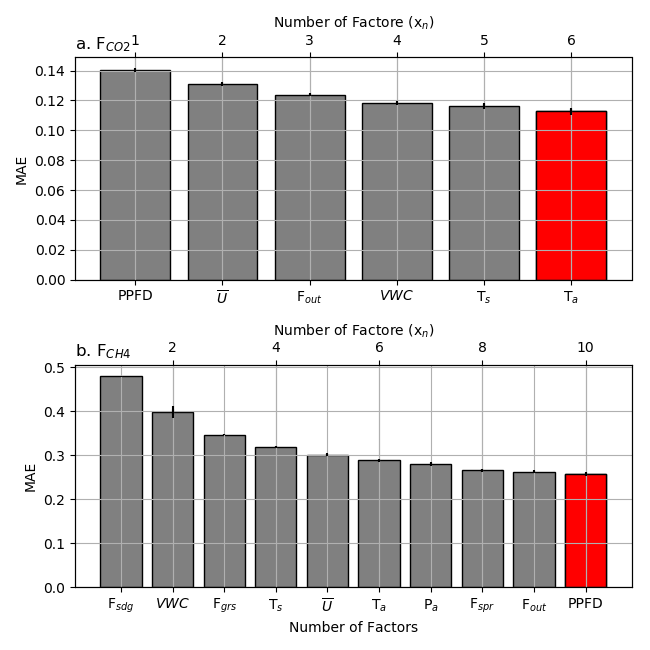

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


   Key                                                Model  \
0  1_2  PPFD_Avg                                              
1  2_0  wind_speed+PPFD_Avg                                   
2  3_9  wind_speed+PPFD_Avg+Out_of_Basin                      
3  4_4  wind_speed+PPFD_Avg+VWC+Out_of_Basin                  
4  5_3  wind_speed+PPFD_Avg+Temp+VWC+Out_of_Basin             
5  6_1  wind_speed+PPFD_Avg+AirTC_Avg+Temp+VWC+Out_of_Basin   

                                  Foundation            Name  Level       MAE  \
0                                             PPFD            1      0.140553   
1  PPFD_Avg                                   $\overline{U}$  2      0.131019   
2  wind_speed+PPFD_Avg                        F$_{out}$       3      0.123815   
3  wind_speed+PPFD_Avg+Out_of_Basin           $VWC$           4      0.118084   
4  wind_speed+PPFD_Avg+VWC+Out_of_Basin       T$_{s}$         5      0.116427   
5  wind_speed+PPFD_Avg+Temp+VWC+Out_of_Basin  T$_{a}$         6      0.1

In [3]:
fig,ax = plt.subplots(2,1,figsize=sizes)
def Bars(ax,Summary,title,Score):
    if Score == 'MAE':
        Levels = Summary.groupby('Level').min()
    else:
        Levels = Summary.groupby('Level').max()
    Sub=Summary[Summary[Score].isin(Levels[Score].values)]
    Sub.sort_values('Level',inplace=True)
    Sub = Sub.loc[Sub['Level']>=1]
    Sub.reset_index(inplace=True,drop=True)
    print(Sub)
    ax.bar(Sub['Level'],Sub[Score],yerr = Sub['SE'],facecolor='grey',edgecolor='black')
    ax.set_ylabel('MAE')
  
    MinMod = Sub[Sub[Score] == Sub[Score].min()]
    Sub['Sig']=False
    Parsimony = Sub.loc[Sub['Model']==Summary.loc[Summary['Level']==0,'Model'].values[0]]
    print(Parsimony)
    ax.bar(Parsimony['Level'],Parsimony[Score],facecolor='red',edgecolor='black')
    yaxy = ax.twiny()
    yaxy.bar(Sub['Level'],Sub[Score],yerr = Sub['SE']*1.96,facecolor='None',edgecolor='None')
    yaxy.bar(Parsimony['Level'],Parsimony[Score],facecolor='None',edgecolor='None')
    yaxy.set_xlabel('Number of Factore (x$_n$)')
    yaxy.grid()
    plt.sca(ax)
    plt.xticks(Sub['Level'].values,Sub['Name'].values)
    ax.set_title(title,loc='left')
    ax.grid()
    print(Parsimony['Model'].values[0].split('+'))
    
ax[1].set_xlabel('Number of Factors')
# Bars(ax[0],fco2_summary,'a. F$_{CO2}$',Score='MAE')
Bars(ax[1],fch4_summary,'b. F$_{CH4}$',Score='MAE')
plt.tight_layout()
plt.savefig('Fig3.png')

# Performance at Level 1

<IPython.core.display.Javascript object>


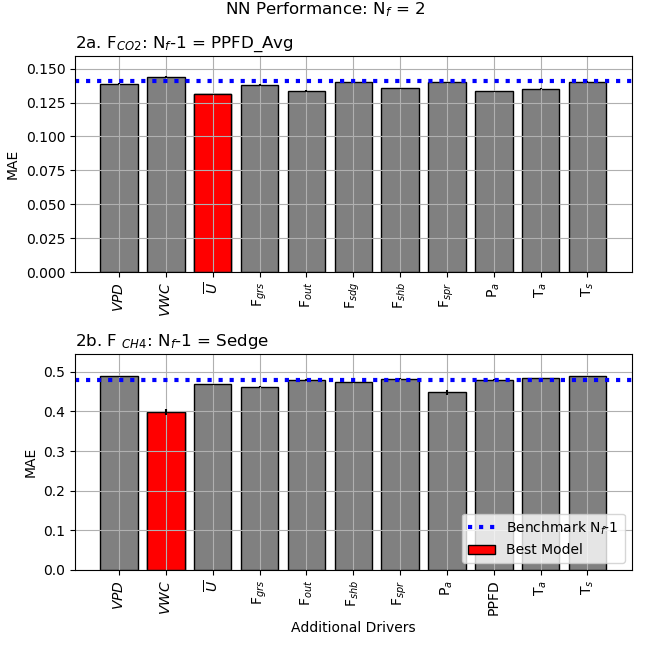

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [4]:
fig,ax = plt.subplots(2,1,figsize=sizes)
def Level_Plot(ax,l,Summary,title,yl,Score='MAE'):
    Sub = Summary.loc[Summary['Level']==l]
    if l == 1:
        ax.bar(Sub['Name'],Sub[Score],yerr=Sub['SE'],facecolor='grey',edgecolor='black')
    else:
        ax.bar(Sub['Name'],Sub[Score],yerr=Sub['SE'],facecolor='grey',edgecolor='black')
#     print(Sub[['Name',Score,'Model']])
    ax.grid()
    ax.set_ylabel('MAE')
    plt.sca(ax)
    plt.xticks(rotation=90)
    ax.set_ylim(0,yl)
    if Score =='MAE':
        Parsimony = Sub.loc[Sub[Score] == Sub[Score].min()]
    else:
        Parsimony = Sub.loc[Sub[Score] == Sub[Score].max()]
    ax.bar(Parsimony['Name'],Parsimony[Score],facecolor='red',edgecolor='black',label = 'Best Model')
    yl = Sub[Score].max()+Sub['SE'].max()
    ax.set_ylim(0,yl+yl*.1)
    ax.set_title(title,loc='left')
    if l >1:
        y = Summary.loc[Summary['Model']==Parsimony['Foundation'].values[0],Score].values
        xl = ax.get_xlim()
        ax.set_xlim(xl[0],xl[1])
        ax.plot([xl[0],xl[1]],[y,y],linestyle = ':',color = 'blue',linewidth=3,label = 'Benchmark N$_f$-1')
        ax.set_title(title+': N$_f$-1 = '+Sub['Foundation'].values[0].replace('+',' & '),loc='left')
#     print(Sub.loc[Sub[Score]<=(Parsimony[Score].values[0]+Parsimony['SE'].values[0])])
    Sub['T'] = Sub[Score]-(Parsimony[Score].min()+Parsimony['SE'].max())
#     print(Sub['T'])

Fignum = '2'
Level = 2
Level_Plot(ax[0],Level,fco2_summary,Fignum+'a. F$_{CO2}$',1.12,Score ='MAE')
Level_Plot(ax[1],Level,fch4_summary,Fignum+'b. F $_{CH4}$',1.12,Score ='MAE')
plt.sca(ax[0])
plt.suptitle('NN Performance: N$_f$ = '+str(Level),x=.5,y=1)
if Level == 1:
    ax[1].set_xlabel('Drivers')
else:
    ax[1].set_xlabel('Additional Drivers')
ax[1].legend(loc=4)

# plt.tight_layout()
plt.tight_layout(rect=[0, 0.0, 1, 0.97])
plt.savefig('Fig'+Fignum+'.png')

<IPython.core.display.Javascript object>


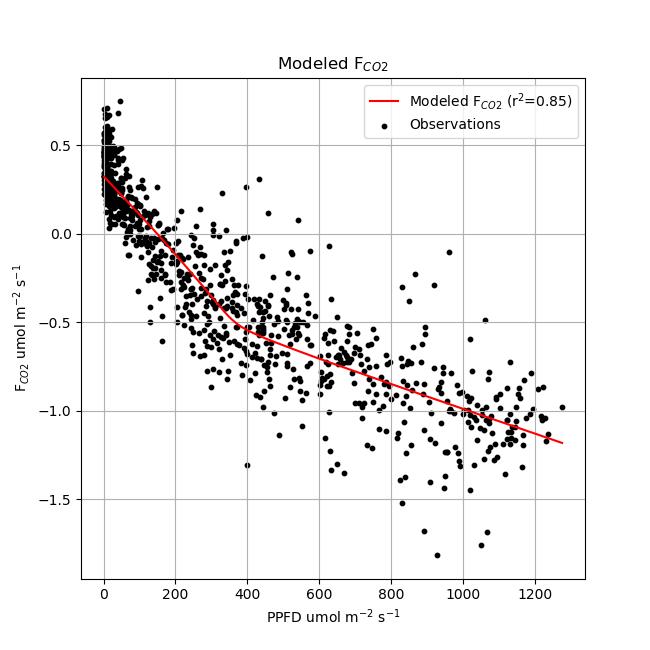

Mean ER:
0.32165858149528503
PI
0.4106754995606283


<IPython.core.display.Javascript object>


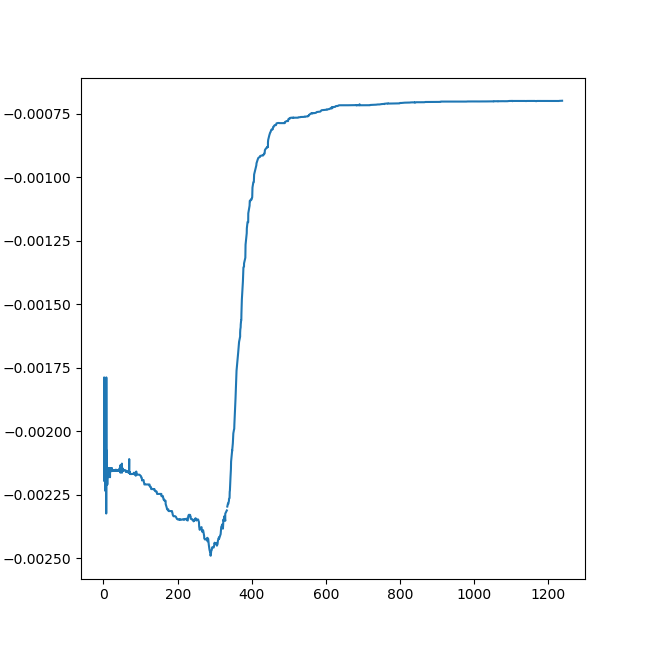

In [5]:
def F1(model,Data,Fill,var,Factor=None):
    Model = 'Model: '+model
    Data['Fill']=Fill[Model] 
    if var == 'fch4':
        Units = 'nmol m$^{-2}$ s$^{-1}$'
        Conv =1# 1e-6 * 16.04246 *3600
    else:
        Units = 'umol m$^{-2}$ s$^{-1}$'
        Conv =1# 1e-6 * 44.0095 *3600
        
    Factor = model
    plt.figure(figsize=sizes)
    Test = Data[[var,'Fill',Factor]].dropna()
    slope, intercept, r_value, p_value, std_err = stats.linregress(Test[var],Test['Fill'])
    Temp = Data[[Factor,'Fill']].sort_values(Factor).dropna(axis=0)
    Temp['Fill']*=Conv
    plt.scatter(Data[Factor],Data[var]*Conv,label = 'Observations',s=10,c='black')
    plt.plot(Temp[Factor],Temp['Fill'],label = 'Modeled F$_{CO2}$ (r${^2}$='+str(np.round(r_value**2,2))+')',c='red')
    Temp3 = (Data.loc[Data[Factor]<=10])
    slope, intercept, r_value, p_value, std_err = stats.linregress(Temp3[Factor],Temp3['Fill']*Conv)
#         print(intercept,slope, r_value, p_value)
    print('Mean ER:')
    ER = (Temp.loc[Temp[Factor]==Temp[Factor].min(),'Fill'].mean())
    print(Temp.loc[Temp[Factor]==Temp[Factor].min(),'Fill'].mean())
#     print('MAE')
#     print(fco2_summary.loc[fco2_summary['Model']=='PPFD_Avg','MAE'])
#     print('CI')
#     print(fco2_summary.loc[fco2_summary['Model']=='PPFD_Avg','MAE'].values[0]**.5/20**.5*stats.t.ppf(1-0.025,20))

        
    plt.title('Modeled F$_{CO2}$')
    plt.grid()
    plt.legend()
    Fignum='4'
    plt.xlabel('PPFD '+Units)
    plt.ylabel('F$_{CO2}$ '+Units)
    plt.savefig('Fig'+Fignum+'.png')
    
    sy = (((Test['Fill']-Test[var])**2).sum()/(Test['Fill'].count()-2))**.5
    xs = Test[Factor].min()
    yhat = Test['Fill'].min()
    
    A = 1/Test['Fill'].count()
    B = (xs-Test[Factor].mean())**2/((Test['Fill'].count()-1)*Test[Factor].std()**2)
#     print(sy,(1+A+B)**.5)
    PI = stats.t.ppf(1-0.025,Test['Fill'].count()-2)*sy*(1+A+B)**.5
    print('PI')
    print(PI)
    
    Temp = Temp.drop_duplicates(subset='PPFD_Avg')
    plt.figure(figsize=sizes)
    Temp['dR/dF'] = np.nan
    Temp['dR/dF'][:-1] = np.diff(Temp['Fill'])/np.diff(Temp[Factor])

    Temp[Temp['dR/dF']==0]=np.nan
    plt.plot(Temp[Factor][:-1],Temp['dR/dF'][:-1])
#     ER = 
    return(ER)
    
    
#     print(Temp.loc[Temp['PPFD']>4.65])
if Site == 'FishIsland':
    Model = 'PPFD'
else:
    Model = 'PPFD_Avg'
ER = F1(Model,Data,fco2_fill,'fco2')
#,['PPFD_Avg','wind_speed'])
# Model = fch4_summary.loc[fch4_summary['Key']=='7_1','Model']
# Model = 'PPFD_Avg+AirTC_Avg+Sedge+VWC+Grass'
# F1(Model,Data,fco2_fill,'fco2',['PPFD_Avg'])
# print(fch4_fill.head())
# print()

<IPython.core.display.Javascript object>


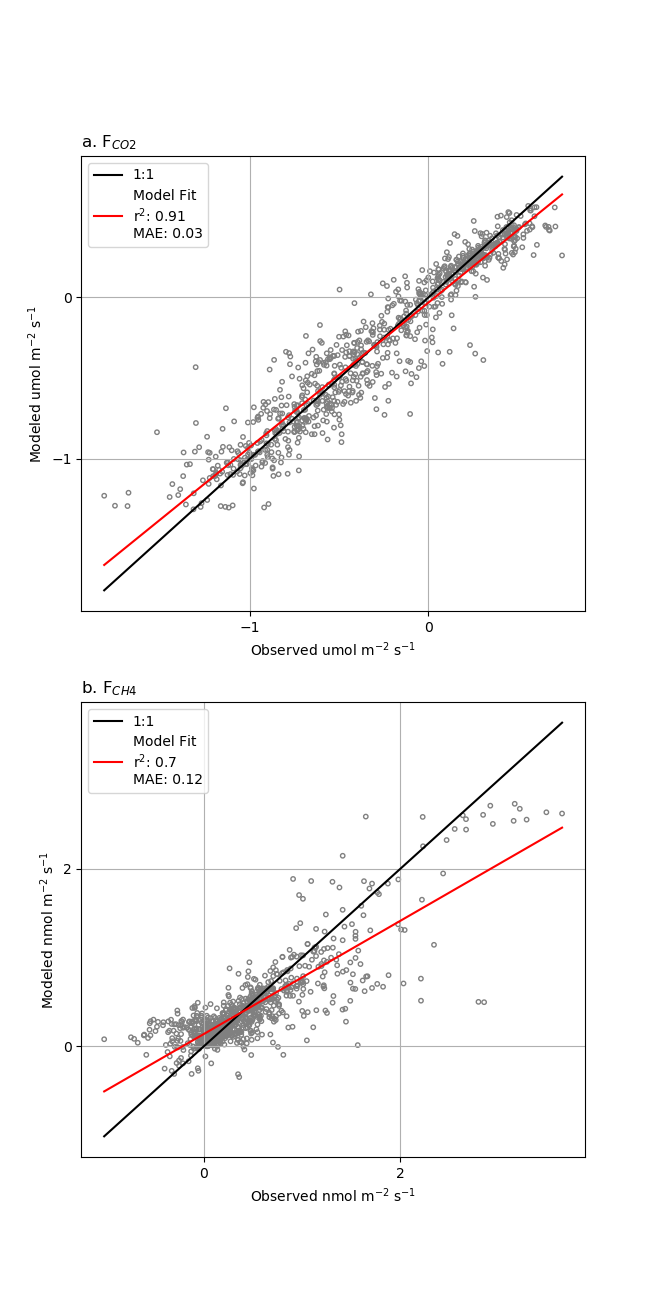

<IPython.core.display.Javascript object>


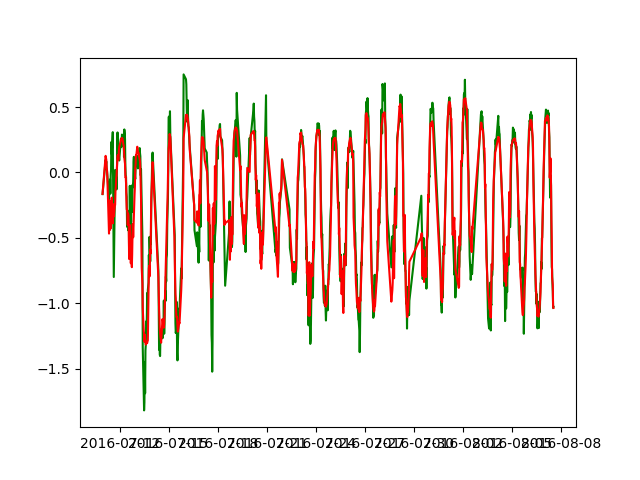

<IPython.core.display.Javascript object>


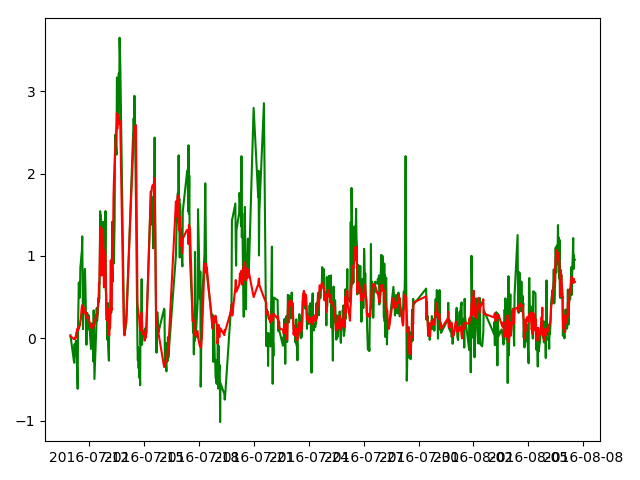

Raw  fco2  Data  -0.284 0.03
Gap Filled  fco2  Data  -0.2402 0.03
ER =  0.32165858149528503
GPP =  -0.5619036972901481

Raw  fch4  Data  0.46 0.04
Gap Filled  fch4  Data  0.4583 0.03


C Ballance =  -0.23 g m$^{-2}$ s$^{-1}$
+- 0.03 g m$^{-2}$ s$^{-1}$


<IPython.core.display.Javascript object>


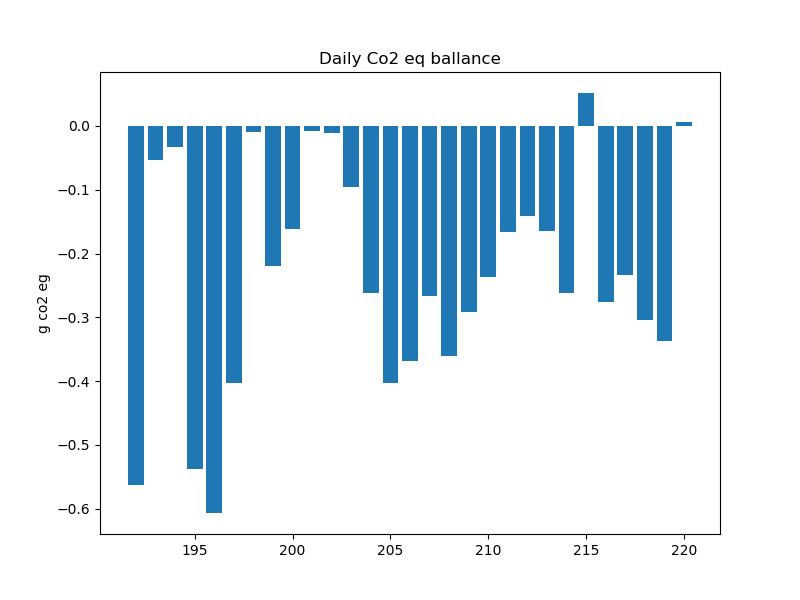

Text(0,0.5,'g co2 eg')

In [6]:

def Full(summary,Data,Fill,var,ax,title):
    ax.locator_params(nbins=5)
#     ax.set(aspect='equal')
    if var == 'fch4':
        Units = 'nmol m$^{-2}$ s$^{-1}$'
    else:
        Units = 'umol m$^{-2}$ s$^{-1}$'
    mod = summary.loc[summary['Level']==0,'Model'].values[0]
#     print(summary.loc[summary['Level']==0])
    Data['Fill']=Fill['BestModel: '+mod]
    Temp = Data[[var,'Fill']].dropna()
    slope, intercept, r_value, p_value, std_err = stats.linregress(Temp[var],Temp['Fill'])
    MAE = metrics.mean_squared_error(Temp[var],Temp['Fill'])
#     print(intercept,slope)
    plt.figure()
    plt.plot(Temp[var],color='green')
    plt.plot(Temp['Fill'],color='red')
    ax.scatter(Temp[var],Temp['Fill'],facecolor='None',edgecolor='grey',marker='o',label=None,s=10)
    Line = np.linspace(Temp[var].min(),Temp[var].max(),10)
    ax.plot(Line,Line,color='black',label = '1:1')
    ax.plot(Line,Line*slope+intercept,color='red',label = 'Model Fit\nr$^2$: '+str(np.round(r_value**2,2))\
                                                              +'\nMAE: '+str(np.round(MAE,2)))
    ax.grid()
    ax.legend()
    ax.set_title(title,loc='left')
    ax.set_ylabel('Modeled '+ Units)
    ax.set_xlabel('Observed '+ Units)
    if var == 'fco2':
        Data[var+'_Fill']=Data[var].fillna(Data['Fill'])#* 1e-6 * 44.0095 *3600
        Data['fill'] = Data['Fill']
    else:
        Data[var+'_Fill']=Data[var].fillna(Data['Fill'])#* 1e-9 * 16.04246 *3600
        
    return(Data)
    
fig,ax=plt.subplots(2,1,figsize=(3.25*2,6.5*2))
Data = Full(fco2_summary,Data,fco2_fill,'fco2',ax[0],'a. F$_{CO2}$')
Data = Full(fch4_summary,Data,fch4_fill,'fch4',ax[1],'b. F$_{CH4}$')
plt.tight_layout()

Data['Cbal'] = (Data['fco2_Fill']+Data['fch4_Fill']*28*1e-3)
for var,conv in zip(['fco2','fch4'],[1,1]):
    Temp = Data[[var,var+'_Fill']]*conv
#     print(Temp.mean())
    print('Raw ',var,' Data ',np.round(Temp[var].mean(),3),np.round(Temp[var].sem()*1.96,2))
    print('Gap Filled ',var,' Data ',np.round(Temp[var+'_Fill'].mean(),4),np.round(Temp[var+'_Fill'].sem()*1.96,2))
    if var == 'fco2':
        print('ER = ', ER)
        print('GPP = ', (Temp[var+'_Fill']-ER).mean())
# print('Raw Fco2 Data ',Data['fco2'].mean()* 1e-6 * 44.0095 *3600,'g m$^{-2}$ h$^{-1}$')
# print('Gap Filled Fco2 Data ',Data['fco2_Fill'].mean(),'g m$^{-2}$ s$^{-1}$')
    print()
# print('Raw Fch4 Data ',Data['fch4'].mean()* 1e-6 * 16.04246 *3600,'mg m$^{-2}$ h$^{-1}$ ')
# print('Gap Filled Fch4 Data ',Data['fch4_Fill'].mean()*1e3,'mg m$^{-2}$ s$^{-1}$' )

print()
print('C Ballance = ',np.round(Data['Cbal'].mean(),2),'g m$^{-2}$ s$^{-1}$')
print('+-',np.round(Data['Cbal'].sem()*1.96,2),'g m$^{-2}$ s$^{-1}$')
Daily = Data.groupby(Data.index.dayofyear).mean()
plt.figure(figsize = (8,6))
plt.bar(Daily.index,Daily['Cbal'])
plt.title('Daily Co2 eq ballance')
plt.ylabel('g co2 eg')

## Factor Effects

<IPython.core.display.Javascript object>


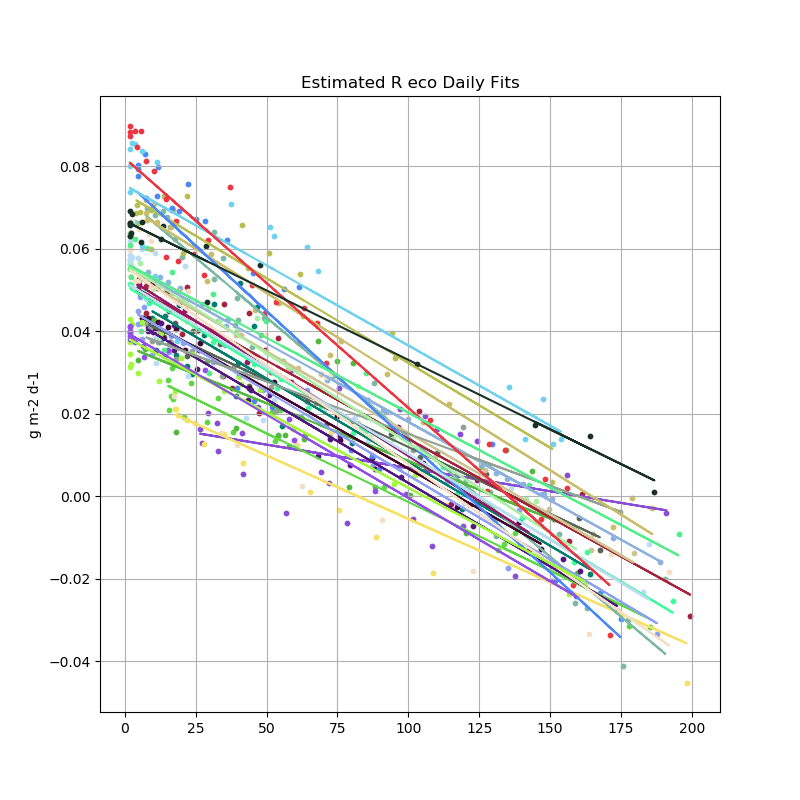

C:\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:785: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


<IPython.core.display.Javascript object>


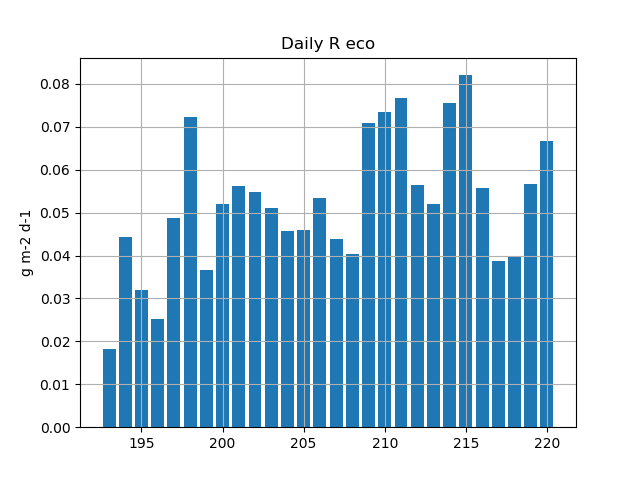

Mean R eco  0.05233740574919253 0.0028838053281864725


In [38]:
import datetime
from scipy.optimize import curve_fit
# print(Data)
Data['OffsetTime'] = (Data.index + datetime.timedelta(hours=0)).dayofyear
def Curve(x,a,b,c):
    return (b*x+c)
Daily = []
Day = []
factor = []
Factor ='PPFD_Avg'
thresh = 8
fig,ax = plt.subplots(figsize=(8,8))
var = 'AirTC_Avg'

for day in (Data['OffsetTime'].unique()):
    Temp = Data.loc[(Data['OffsetTime']==day)&(Data[Factor]<=200),[Factor,var,'fill']]
#     print(Temp)#,c='black')
    Temp = Temp.dropna()
    if Temp.shape[0]>=int(thresh):
        C=np.random.rand(3)
        popt, pcov = curve_fit(Curve, Temp[Factor].values, Temp['fill'].values)
        ax.plot(Temp[Factor],Curve(Temp[Factor].values,*popt)* 1e-6 * 44.0095 *3600,c=C)
        ax.scatter(Temp[Factor],Temp['fill']* 1e-6 * 44.0095 *3600,s=10,c=C,
                label = 'Mean R = '+str(np.round(Curve(0,*popt),2)))
        Daily.append(Curve(0,*popt))
        Day.append(day)
    else:
        Daily.append(np.nan)
        Day.append(day)
    factor.append(Temp[var].median())
# plt.ylim(0,4.5)
# plt.xlim(-10,100)
Day = np.asanyarray(Day)
Daily = np.asanyarray(Daily)* 1e-6 * 44.0095 *3600
# plt.legend()
plt.title('Estimated R eco Daily Fits')
plt.ylabel('g m-2 d-1')
plt.grid()

plt.show()
fig,ax = plt.subplots()
ax.bar(Day,Daily)
plt.title('Daily R eco')
plt.ylabel('g m-2 d-1')

print('Mean R eco ',np.nanmean(Daily),np.nanstd(Daily)/Daily.shape[0]**.5)
plt.grid()
# plt.figure()
# plt.scatter(Data['PPFD_Avg'],Data['fill'])
Data['fco2_Fill']=Data['fco2_Fill']*1e-6 * 44.0095 *3600

In [39]:

# from sklearn import metrics
# from sklearn.model_selection import RepeatedKFold
# from sklearn.model_selection import train_test_split

# def R_func(T,r1,r2,r3):
#     return(1/(r1*r2**T+r3))
# def P_func(PPFD,MQY,PM):
#     cv =.7
#     return(MQY*PPFD + PM - ((MQY*PPFD + PM)**2 - 4*cv*MQY*PPFD*PM)**.5/(2*cv))
# def Line(X,m,b):
#     return(m*X+b)

# Dark_Thresh = 20
# Dark = Data[(Data['PPFD_Avg']<=Dark_Thresh)&(Data['fco2_Fill']>=0)]
# Dark = Dark[['fco2_Fill','PPFD_Avg','Temp','u*','VWC']].dropna()
# # plt.plot(Dark['fco2_Fill'])
# N=10
# Pred = []
# MAE = []
# for i in range(N):
#     X_train,X_test,y_train,y_test=train_test_split(Dark['Temp'],Dark['fco2_Fill'], test_size=0.1, random_state=i)
#     popt_r, pcov = curve_fit(R_func, X_train, y_train,p0=( 4.59262144,0.5875255,0.27508822))
# #     print(R_func(X_train,*popt_r))
#     MAE.append(metrics.mean_squared_error(y_test,R_func(X_test,*popt_r)))
#     Pred.append(R_func(Data['Temp'],*popt_r))
# #     print(metrics.mean_squared_error(y_test,
# #                                     R_func(X_test,*popt_r)))
# MAE = np.asanyarray(MAE).mean()
# Data['R'] = np.asanyarray(Pred).mean(axis=0)

# print(Data['R'].mean(),(MAE**.5/N**.5)*stats.t.ppf(1-0.025,N))
# plt.figure()
# plt.plot(Data['R'])
# print(MAE)


# print(Dark['fco2_Fill'].count())

# popt_r, pcov = curve_fit(R_func, Dark['Temp'], Dark['fco2_Fill'],p0=( 4.59262144,0.5875255,0.27508822))
# # Data['R'] = Data['fco2_Fill']
# # Data.loc[Data['PPFD_Avg']>10,['R']]=np.nan
# Data['R'] = R_func(Data['Temp'],*popt_r)# Data['R'].fillna(R_func(Data['Temp'],*popt_r))
# Data['GPP'] = (Data['R']-Data['fco2_Fill'])
# P = Data[Data['PPFD_Avg']>=Dark_Thresh]
# P = P[['GPP','PPFD_Avg']].dropna()
# popt_p, pcov = curve_fit(P_func, P['PPFD_Avg'], P['GPP'],p0=(.003,12))
# Data['GPP'] = Data['GPP'].fillna(P_func(Data['PPFD_Avg'],*popt_p))
# Data['GPP_fill'] = P_func(Data['PPFD_Avg'],*popt_p)
# ## Ordered Data for Plotting fits
# Temp = np.arange(Data['Temp'].min(),Data['Temp'].max(),.25)
# PAR = np.arange(Data['PPFD_Avg'].min(),Data['PPFD_Avg'].max(),1)

# ## Calculate r2
# Rsq_Resp = metrics.r2_score(Dark['fco2_Fill'].values,R_func(Dark['Temp'],*popt_r))
# MAE = metrics.r2_score(Dark['fco2_Fill'].values,R_func(Dark['Temp'],*popt_r))
# # print((MAE*2/Dark['PPFD_Avg'].count())**.5)
# Rsq_GPP = metrics.r2_score(P['GPP'].values,P_func(P['PPFD_Avg'],*popt_p))

# fig,axes = plt.subplots(nrows = 1,ncols = 1,figsize = (5,5))
# axes.scatter(Dark['Temp'],Dark['fco2_Fill'],label = 'Obs. PPFD < '+str(Dark_Thresh)+'\numol m$^2$ s$^-1$')
# axes.plot(Temp,R_func(Temp,*popt_r),color = 'red',label = 'Modeled: r$^2$ = '+str(np.round(Rsq_Resp,2)))
# axes.legend(loc = 2,fontsize = 16)
# axes.set_ylabel('R$_e$ umol m$^2$ s$^-$$^1$',fontsize = 18)
# axes.set_xlabel('Soil Temp C$^o$',fontsize = 18)
# axes.set_title('Ecosystem Respiration',fontsize = 28)
# plt.show()
# PRed =R_func(Temp,*popt_r)
# print(Dark['PPFD_Avg'].count(),MAE)
# print(Data['R'].mean(),(MAE**.5/N**.5)*stats.t.ppf(1-0.025,N))
# print(np.mean(PRed),np.std(PRed)/(PRed.shape[0]**.5)*1.96)#,Dark['fco2_Fill'].sem()*1.96)
# plt.figure()
# plt.scatter(Dark['fco2_Fill'].values,R_func(Dark['Temp'],*popt_r))
# plt.ylabel('Model')

In [40]:
# print(Data['Day'])

# Individual Model Performance